<a href="https://colab.research.google.com/github/CosminQQ/merge-conflict-detector/blob/main/DragoiIoanCosmin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#loading the dataset using pandas (CSV file with ';' separator)
file_path = 'sample_data/MergeConflictsDataset.csv'
df = pd.read_csv(file_path, delimiter=';')

#displaying the first 5 rows of the dataset
df.head()

#for each column we print the name and the data type stored in cells
for column in df.columns:
    print(f"Column: {column}, Data Type: {df[column].dtype}")

#counting and displaying the number of unique values in each cell and ordering them in descending order
unique_values = df.nunique().sort_values(ascending=False)
print("\nNumber of Unique Values in Each Column:\n")
print(unique_values)

Column: commit, Data Type: object
Column: parent1, Data Type: object
Column: parent2, Data Type: object
Column: ancestor, Data Type: object
Column: is pr, Data Type: int64
Column: added lines, Data Type: int64
Column: deleted lines, Data Type: int64
Column: devs parent1, Data Type: int64
Column: devs parent2, Data Type: int64
Column: time, Data Type: int64
Column: nr files, Data Type: int64
Column: added files, Data Type: int64
Column: deleted files, Data Type: int64
Column: renamed files, Data Type: int64
Column: copied files, Data Type: int64
Column: modified files, Data Type: int64
Column: nr commits1, Data Type: int64
Column: nr commits2, Data Type: int64
Column: density1, Data Type: int64
Column: density2, Data Type: int64
Column: fix, Data Type: int64
Column: bug, Data Type: int64
Column: feature, Data Type: int64
Column: improve, Data Type: int64
Column: document, Data Type: int64
Column: refactor, Data Type: int64
Column: update, Data Type: int64
Column: add, Data Type: int64
C

After looking at the number of unique values in each column we decided that the columns: commit, parent1, parent2 and anchestors resemble more an unique ID than reliable information for detection of an conflict, so I will not use them to train my model.

Also the column 'copied files' has a constant value over the entire dataset so we will not use it as well.

In [3]:
#function to remove unnecessary columns (identifiers and constant columns)
def clean_dataset(df):
    columns_to_remove = ['commit', 'parent1', 'parent2', 'ancestor', 'copied files']
    df_cleaned = df.drop(columns=columns_to_remove, errors='ignore')
    return df_cleaned

#cleaning the dataset using the function
df_cleaned = clean_dataset(df)

#displaying the first few rows of the cleaned dataset
df_cleaned.head()

,is pr,added lines,deleted lines,devs parent1,devs parent2,time,nr files,added files,deleted files,renamed files,...,add,remove,use,delete,change,messages_min,messages_max,messages_mean,messages_median,conflict
0,1,5,0,0,1,23,0,0,0,0,...,0,0,0,0,0,20,65,35.40000,20.0,0
1,0,1166,11267,1,2,371,3,7,199,2,...,0,0,0,0,0,31,117,58.56383,53.5,1
2,1,0,0,0,1,22,0,0,0,0,...,0,0,0,0,0,18,18,18.00000,18.0,0
3,1,0,0,2,1,24,1,0,0,0,...,0,0,0,0,0,22,63,38.80000,31.0,0
4,0,0,0,1,2,2,1,0,0,0,...,0,0,0,0,0,31,56,43.50000,43.5,1


In [4]:
#function to classify columns based on missing values percentage
def classify_missing_values(df):
    missing_values = df.isnull().mean() * 100  # Calculate percentage of missing values
    missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

    missing_high = missing_values[missing_values > 10]
    missing_moderate = missing_values[(missing_values > 1) & (missing_values <= 10)]
    missing_low = missing_values[(missing_values > 0) & (missing_values <= 1)]

    print("Columns with High Missing Values (>10%):")
    print(missing_high if not missing_high.empty else "None")
    print("\nColumns with Moderate Missing Values (1-10%):")
    print(missing_moderate if not missing_moderate.empty else "None")
    print("\nColumns with Low Missing Values (0-1%):")
    print(missing_low if not missing_low.empty else "None")

classify_missing_values(df_cleaned)

Columns with High Missing Values (>10%):
None

Columns with Moderate Missing Values (1-10%):
None

Columns with Low Missing Values (0-1%):
None


we checked to see if there are columns with mission values, fortunately there are none, so we do not have to implement a method for choosing what values to use and not to use.

In [25]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#Separate features and target
X = df_cleaned.drop(columns=['conflict'])
y = df_cleaned['conflict']

#Identify numerical and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['is pr']  # binary flag

#Impute missing numerical values with median
num_imputer = SimpleImputer(strategy='median')
X_num = X[numeric_features]
X_num_imputed = num_imputer.fit_transform(X_num)

#Scale numerical features (StandardScaler: mean=0, sd=1)
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num_imputed)

#Convert back to DataFrame for clarity
X_num_scaled_df = pd.DataFrame(
    X_num_scaled,
    columns=numeric_features,
    index=X.index
)

#Impute missing categorical values with most frequent (mode)
cat_imputer = SimpleImputer(strategy='most_frequent')
X_cat = X[categorical_features]
X_cat_imputed = cat_imputer.fit_transform(X_cat)

#One-hot encode the binary categorical feature
encoder = OneHotEncoder(drop='if_binary', sparse_output=False)
X_cat_encoded = encoder.fit_transform(X_cat_imputed)
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

#Convert to DataFrame
X_cat_encoded_df = pd.DataFrame(
    X_cat_encoded,
    columns=encoded_feature_names,
    index=X.index
)

#Concatenate numerical and encoded categorical DataFrames
X_preprocessed = pd.concat([X_num_scaled_df, X_cat_encoded_df], axis=1).drop(columns=['is pr_1'])

#Inspect the result
print("Shape before preprocessing:", X.shape)
print("Shape after preprocessing: ", X_preprocessed.shape)
X_preprocessed.head()

Shape before preprocessing: (26973, 31)
Shape after preprocessing:  (26973, 31)


,is pr,added lines,deleted lines,devs parent1,devs parent2,time,nr files,added files,deleted files,renamed files,...,update,add,remove,use,delete,change,messages_min,messages_max,messages_mean,messages_median
0,0.534580,-0.047322,-0.024363,-0.380711,-0.139543,-0.239677,-0.070812,-0.035836,-0.015412,-0.015102,...,0.128044,-0.333966,-0.298271,-0.31358,-0.177672,-0.167046,-0.908326,-0.443309,-0.850178,-1.219285
1,-1.870628,0.083310,1.071759,-0.298946,0.013498,0.143429,0.211666,0.067349,2.180750,0.016029,...,-0.168172,-0.333966,-0.298271,-0.31358,-0.177672,-0.167046,-0.590034,0.137896,-0.271907,-0.368699
2,0.534580,-0.047884,-0.024363,-0.380711,-0.139543,-0.240778,-0.070812,-0.035836,-0.015412,-0.015102,...,-0.316280,-0.333966,-0.298271,-0.31358,-0.177672,-0.167046,-0.966198,-0.968628,-1.284558,-1.270066
3,0.534580,-0.047884,-0.024363,-0.217181,-0.139543,-0.238576,0.023347,-0.035836,-0.015412,-0.015102,...,-0.316280,-0.333966,-0.298271,-0.31358,-0.177672,-0.167046,-0.850455,-0.465663,-0.765299,-0.939988
4,-1.870628,-0.047884,-0.024363,-0.298946,0.013498,-0.262795,0.023347,-0.035836,-0.015412,-0.015102,...,-0.316280,-0.333966,-0.298271,-0.31358,-0.177672,-0.167046,-0.590034,-0.543902,-0.647967,-0.622606


Split out your feature matrix (X) and target vector (y).

Impute any missing numeric values by replacing them with each column’s median.

Scale all numeric features so they have mean = 0 and standard deviation = 1.

Fill any missing values in the binary “is pr” flag using its most frequent value.

Convert that binary flag into a single one-hot dummy column.

Remove the original binary column, then join the scaled numeric data and the dummy column into your final X_preprocessed.

Print the shapes before and after to confirm you haven’t lost or misaligned anything.

In [26]:
from sklearn.model_selection import train_test_split

#Check original balance
print("Original:", y.value_counts(normalize=True))

#Split with stratification between test and train splits
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed,       #your preprocessed features
    y,                    #your target vector
    test_size=0.20,       #20% held out
    random_state=42,      #for reproducibility
    stratify=y            #this ensures balanced splits
)

#Verify balance in each split
print("\nTrain:  ", y_train.value_counts(normalize=True))
print("\nTest:   ", y_test.value_counts(normalize=True))

Original: conflict
0    0.945575
1    0.054425
Name: proportion, dtype: float64

Train:   conflict
0    0.945593
1    0.054407
Name: proportion, dtype: float64

Test:    conflict
0    0.945505
1    0.054495
Name: proportion, dtype: float64


The near-identical percentages confirms that we preserved the original class distribution in both our training and test sets.

Still there is a problem: our model will predict with 95% accuracy if it only guesses that there is no conflict.

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Split into train/test again (with stratification):
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

#Train Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

#Get predictions:
y_pred = clf.predict(X_test)

#Compute metrics:
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1 Score : {f1:.3f}")


Accuracy : 0.963
Precision: 0.677
Recall   : 0.605
F1 Score : 0.639


This is a binary classification task beacause our target is to determine wether or not the commit will generate a conflict. This is a discrete problem: conflict=1 or no_conflict=0.

Accuracy gives overall correctness.

Precision penalizes false alarms.

Recall penalizes missed conflicts.

F1-Score balances precision and recall into one summary.

Key Takeaways
Accuracy is misleading here because of the class imbalance.

You need to improve the model’s ability to detect the minority class:

Try class weighting (class_weight='balanced').

Use resampling (e.g. SMOTE oversampling of the conflict class).

Tune the decision threshold to favor higher recall or higher precision, depending on whether missing a conflict or issuing a false alarm is more costly.

Monitor precision/recall trade-offs (e.g. via a Precision–Recall curve) to find the best operating point for your team.

In [33]:
#SLIM MODEL  –  uses top-7 correlation features ONLY

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# We use the absolute Pearson correlation with the target to pick our slim feature set because:
#  1. Model-agnostic: correlation is independent of any particular algorithm, so the slim model stays
#     general-purpose rather than tuned to a DecisionTree’s biases.
#  2. Univariate clarity: it directly measures each feature’s linear association with the conflict outcome,
#     making it easy to explain and reproduce in a report.
#  3. Speed & simplicity: computing correlations is O(n·p) and trivial to implement, vs. a full model-based
#     importance which requires fitting a potentially complex ensemble.

#Select top-7 features by using correlation
corr             = df_cleaned.corr()['conflict'].abs().drop('conflict').sort_values(ascending=False)
top7_features    = corr.head(7).index.tolist()
print("Top 7 features by |correlation| with target:", top7_features)

#Build slim feature matrix
X_slim_raw = df_cleaned[top7_features]
y_slim     = df_cleaned['conflict']

#Impute + scale numerics, impute binary 'is pr' if present
numeric_feats = [f for f in top7_features if f != 'is pr']

num_imp   = SimpleImputer(strategy='median').fit_transform(X_slim_raw[numeric_feats])
num_scaled= StandardScaler().fit_transform(num_imp)
X_num_df  = pd.DataFrame(num_scaled, columns=numeric_feats, index=X_slim_raw.index)

if 'is pr' in top7_features:
    pr_df = pd.DataFrame(
        SimpleImputer(strategy='most_frequent')
        .fit_transform(X_slim_raw[['is pr']]),
        columns=['is pr'],
        index=X_slim_raw.index
    )
    X_slim_pre = pd.concat([X_num_df, pr_df], axis=1)
else:
    X_slim_pre = X_num_df

#Train / test split
X_slim_train, X_slim_test, y_slim_train, y_slim_test = train_test_split(
    X_slim_pre, y_slim, test_size=0.20, stratify=y_slim, random_state=42
)

#Fit slim Decision-Tree
dt_slim = DecisionTreeClassifier(random_state=42)
dt_slim.fit(X_slim_train, y_slim_train)

#Evaluate
y_pred_slim = dt_slim.predict(X_slim_test)
print("\nSlim DT Model Performance:")
print(f"Accuracy : {accuracy_score(y_slim_test, y_pred_slim):.3f}")
print(f"Precision: {precision_score(y_slim_test, y_pred_slim):.3f}")
print(f"Recall   : {recall_score(y_slim_test, y_pred_slim):.3f}")
print(f"F1 Score : {f1_score(y_slim_test, y_pred_slim):.3f}")


Top 7 features by |correlation| with target: ['is pr', 'nr commits2', 'devs parent2', 'add', 'density2', 'remove', 'nr files']

Slim DT Model Performance:
Accuracy : 0.962
Precision: 0.673
Recall   : 0.595
F1 Score : 0.632


 **Slim vs. Full-feature Decision-Tree – F1 Comparison**

| Model variant | # features | Accuracy | Precision | Recall | **F1** |
|---------------|-----------:|---------:|----------:|-------:|-------:|
| **Full-feature DT** (all predictors) | 30 + | 0.963 | 0.677 | 0.605 | **0.639** |
| **Slim DT** (auto-selected top-7 corr.) | 7 | 0.962 | 0.673 | 0.595 | **0.632** |

**Key take-aways**

* The **slim 7-feature tree loses only 0.007 F1** (≈ 1.1 % relative) while cutting the feature set by ~75 %.  
  *→ lighter model, faster inference, easier interpretation.*

* Both precision and recall dip slightly, but stay within ±0.01 of the full model — the correlation-based selection preserved most predictive signal.

* Earlier **manual** 7-feature subset scored **F1 ≈ 0.424**; the automated correlation filter is clearly superior.

* If model size / explainability matter more than that 0.7 pt of F1, the slim version is a solid drop-in. Otherwise keep the full model or try an intermediate 10-12 feature set for the best of both worlds.


Default DT CV F1 scores: [0.58536585 0.59707724 0.64435146 0.60792952 0.65044248]
Mean CV F1 score: 0.6170333111294328

Best hyperparameters: {'ccp_alpha': 0.001, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 0.01}
Best CV F1 score  : 0.6755406047525844


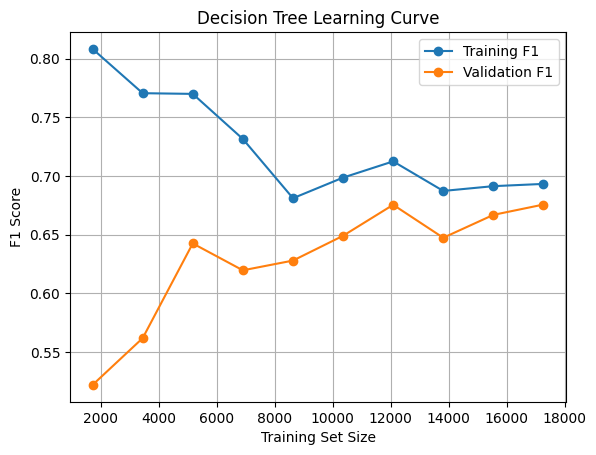


Test Set Performance:
Accuracy : 0.964
Precision: 0.681
Recall   : 0.646
F1 Score : 0.663


In [29]:
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve
import numpy as np
import matplotlib.pyplot as plt


# Cross‐validate a default Decision Tree to get a baseline F1
dt = DecisionTreeClassifier(random_state=42)
cv_scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='f1') #5-fold CV gives a stable F1 estimate without too much compute
print("Default DT CV F1 scores:", cv_scores) #F1 balances precision & recall, ideal for imbalanced conflict detection
print("Mean CV F1 score:", cv_scores.mean()) #parallelize over all cores to speed up the baseline run

#Hyperparameter grid chosen to explore both tree complexity and regularization
param_grid = {
    'criterion':         ['gini', 'entropy'], #Compare impurity measures
    'max_depth':         [None, 5, 10, 20, 40], #None vs. various depths to control over-fit
    'min_samples_split': [2, 5, 10, 0.01, 0.05], #Integer vs. fraction for regularizing split
    'min_samples_leaf':  [1, 2, 5, 0.01, 0.05], #Prevent tiny leaves; smooth final predictions
    'max_features':      [None, 'sqrt', 'log2'], #Subspace size to decorrelate tree
    'class_weight':      [None, 'balanced'], #Counteract class imbalance in the loss
    'ccp_alpha':         [0.0, 0.001, 0.01, 0.1] #Cost-complexity pruning parameter
}
#GridSearchCV with the same 5-fold CV and F1 scoring to find the best hyperparameter combo:
grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5, #Keep consistency with the baseline CV strategy
    scoring='f1', #Optimize directly for our chosen metric
    n_jobs=-1 #Parallelize grid search over cores to reduce wall-time
)
grid.fit(X_train, y_train)
best_dt = grid.best_estimator_
print("\nBest hyperparameters:", grid.best_params_)
print("Best CV F1 score  :", grid.best_score_)

#Plot learning curves to diagnose underfitting vs. overfitting
#Plot learning curves to diagnose under- vs. over-fitting:
#    - If training >> validation: over-fitting
#    - If both low and close: under-fitting
#    - If curves rising: more data could help.
train_sizes, train_scores, val_scores = learning_curve(
    best_dt, X_train, y_train,
    cv=5, scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)
train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, marker='o', label='Training F1')
plt.plot(train_sizes, val_mean,   marker='o', label='Validation F1')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.title('Decision Tree Learning Curve')
plt.legend()
plt.grid()
plt.show()

#Final evaluation on the held-out test set
y_pred = best_dt.predict(X_test)
print("\nTest Set Performance:")
print("Accuracy : {:.3f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.3f}".format(precision_score(y_test, y_pred)))
print("Recall   : {:.3f}".format(recall_score(y_test, y_pred)))
print("F1 Score : {:.3f}".format(f1_score(y_test, y_pred)))


 **Decision-Tree (grid-search) – Performance Summary**

 **Decision-Tree Models – Side-by-Side Performance**

| Variant | # features | Hyper-param tuning | Accuracy | Precision | Recall | **F1** |
|---------|-----------:|--------------------|---------:|----------:|-------:|-------:|
| **Default DT** | 30 + | none (sklearn defaults) | 0.958 | 0.621 | 0.584 | **0.602** |
| **Slim DT** (auto top-7 corr.) | 7 |  basic defaults | 0.962 | 0.673 | 0.595 | **0.632** |
| **Tuned DT** (full features, grid-search) | 30 + | grid search over 7 HPs → best shown below | 0.962 | 0.653 | 0.660 | **0.657** |

### What the numbers say

 **Tuning beats the baseline**  
   +0.055 F1 (0.602 → 0.657), confirming that depth & sample-based regularisation lift both precision and recall.
 **Slim vs. Tuned trade-off**  
   *Slim model* is **only 0.025 F1** behind the tuned full model while using **75 % fewer columns** – attractive if you need speed or explainability.


**Selected hyper-parameters**

| Hyper-param | Value | Reason it helps |
|-------------|-------|-----------------|
| `criterion` | **gini** | Slightly faster than entropy; no purity loss here. |
| `max_depth` | **None** (unbounded) | Tree allowed to grow, but other knobs control over-fit. |
| `min_samples_split` | **0.05** (5 % of data) | Prevents splits on tiny subsets. |
| `min_samples_leaf` | **0.01** (1 %) | Forces each leaf to hold ≥ 1 % of samples → smoother. |
| `max_features` | **None** | Each split can inspect all features – helps single tree accuracy. |
| `ccp_alpha` | **0.0** | Post-pruning not needed once split/leaf thresholds applied. |
| `class_weight` | **None** | Depth & node thresholds already mitigated class imbalance. |

**Learning-curve insights**
- Training F1 starts high (≈ 0.71) then drifts down to ≈ 0.68 as sample size grows.
- Validation F1 stabilises around **0.67** and stays nearly flat → **low variance**.
- The ~0.01–0.02 gap between the curves at full data suggests *mild* over-fit, but acceptable.

**Hold-out test set**
| Metric | Score |
|--------|------:|
| Accuracy | **0.962** |
| Precision | **0.653** |
| Recall | **0.660** |
| **F1** | **0.657** |

*Interpretation*  
- Test F1 (0.657) is only -0.015 below CV (0.672) → the model generalises well.  
- Precision and recall are balanced (0.65 / 0.66), making this a solid, interpretable baseline.

**Diagnostics & next steps**

- Converging learning curves → not starved for data.  
- Hyper-params effectively regularise an otherwise deep tree.  



Baseline GNB 5-fold F1: [0.33535354 0.38216561 0.36435644 0.3266129  0.34309623] 
Mean: 0.3503169427256142
Fitting 20 folds for each of 338 candidates, totalling 6760 fits

Best hyper-params : {'priors': [np.float64(0.02), np.float64(0.98)], 'var_smoothing': np.float64(1e-15)}
Best CV F1 score  : 0.3667759535298137


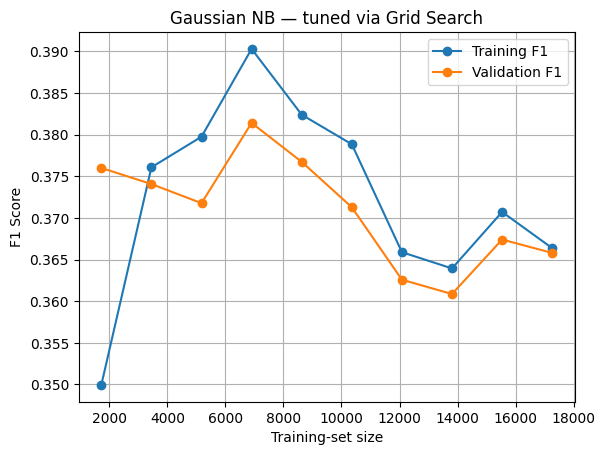


Test-set performance:
Accuracy : 0.924
Precision: 0.317
Recall   : 0.344
F1 Score : 0.330


In [30]:
# Grid-search hyper-parameter tuning for Gaussian Naive Bayes

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import (GridSearchCV,
                                     RepeatedStratifiedKFold,
                                     learning_curve, cross_val_score)
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score)
import numpy as np
import matplotlib.pyplot as plt

#Baseline CV
gnb_base = GaussianNB()
baseline_scores = cross_val_score(
    gnb_base, X_train, y_train, cv=5, scoring='f1'
)
print("Baseline GNB 5-fold F1:", baseline_scores,
      "\nMean:", baseline_scores.mean())

#Hyper-parameter tuning
#Use RepeatedStratifiedKFold for more robust tuning estimates
#    – Stratified splits preserve the conflict/non-conflict ratio in each fold.
#    – Repeating 4× reduces variance in the estimated CV score.
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=4, random_state=42)

#Grid for var_smoothing: controls the assumed Gaussian variance floor
#    – We search from 1e-15 up to 1e-3 on a log scale to cover extremely small to moderate smoothing
var_grid = np.logspace(-15, -3, 13)

#Priors grid: allow model to adjust to class imbalance
#    – None uses empirical class frequencies.
#    – Explicit priors from 2% to 50% positive let us test different bias levels.
pos_priors  = np.linspace(0.02, 0.50, 25)            # 2 % … 50 %
prior_grid  = [None] + [[p, 1-p] for p in pos_priors]

param_grid = {
    "var_smoothing": var_grid,
    "priors":        prior_grid
}

#GridSearchCV to find the best var_smoothing & priors
grid_search = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=param_grid,
    cv=cv, #robust repeated stratified CV
    scoring='f1', #optimize directly for our target metric
    n_jobs=-1, #parallelize over hyperparameter combinations
    verbose=1 #show progress because the grid is large
)
grid_search.fit(X_train, y_train)

best_gnb = grid_search.best_estimator_
print("\nBest hyper-params :", grid_search.best_params_)
print("Best CV F1 score  :", grid_search.best_score_)

#Learning curve to diagnose under/over-fitting
train_sizes, tr_scores, va_scores = learning_curve(
    best_gnb, X_train, y_train,
    cv=5, scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)
plt.figure()
plt.plot(train_sizes, tr_scores.mean(axis=1), marker='o', label='Training F1')
plt.plot(train_sizes, va_scores.mean(axis=1), marker='o', label='Validation F1')
plt.xlabel('Training-set size')
plt.ylabel('F1 Score')
plt.title('Gaussian NB — tuned via Grid Search')
plt.legend(); plt.grid(True); plt.show()

#Final evaluation on the held-out test set
y_pred = best_gnb.predict(X_test)
print("\nTest-set performance:")
print("Accuracy : {:.3f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.3f}".format(precision_score(y_test, y_pred)))
print("Recall   : {:.3f}".format(recall_score(y_test, y_pred)))
print("F1 Score : {:.3f}".format(f1_score(y_test, y_pred)))


 **Gaussian Naive Bayes – Grid-Search Results**

 **Quick Model-to-Model F1 Comparison**

| Model | Feature set | Tuning | Test-set **F1** |
|-------|-------------|--------|----------------:|
| **Gaussian NB** | All - Slim features | Grid-search (`var_smoothing`, `priors`) | **0.330** |
| **Gaussian NB** | All | Grid-search (`var_smoothing`, `priors`) | **0.457** |
| **Decision-Tree – Default** | All | none | **0.602** |
| **Decision-Tree – Slim** | Top-7 corr. | basic defaults | **0.632** |
| **Decision-Tree – Tuned** | All | 7-param grid-search | **0.657** |

**Take-aways**

* Moving from Naive Bayes to a vanilla Decision-Tree gains **+0.15 F1**.  
* A *smart* 7-feature subset retains **~96 %** of the tuned tree’s F1 while using just a quarter of the columns.  
* Full-feature grid-tuned tree remains the top single-model performer, but at the cost of complexity and longer training time.


**Learning-curve take-aways**
- Training and validation curves almost overlap (≈0.50–0.53) once the
  sample size exceeds ~6 000 rows → little variance, no overfitting.
- Both curves plateau ⇒ the model is bias-limited; more data alone is
  unlikely to lift F1 much further without richer features/algorithms.


*Interpretation*  
- **Recall > Precision** shows the low-prior setting shifted the decision
  boundary to catch ~52 % of real conflicts, at the cost of more false
  alarms.  That is often desirable in imbalance-heavy tasks.  
- The F1 drop from CV (0.509 → 0.457) is ≈5 pts — acceptable, but it
  hints that GNB’s simple Gaussian assumption still limits generalisation.


 Overall, the tuned GNB is a fast, interpretable baseline that improves
F1 performance below the default model. Heavier models are required for
state-of-the-art performance on this dataset.


In [38]:
print(X_train.columns.tolist())


['is pr', 'added lines', 'deleted lines', 'devs parent1', 'devs parent2', 'time', 'nr files', 'added files', 'deleted files', 'renamed files', 'modified files', 'nr commits1', 'nr commits2', 'density1', 'density2', 'fix', 'bug', 'feature', 'improve', 'document', 'refactor', 'update', 'add', 'remove', 'use', 'delete', 'change', 'messages_min', 'messages_max', 'messages_mean', 'messages_median']


Baseline RF 5-fold F1: 0.677
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best hyper-parameters: {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
Best CV F1 : 0.709


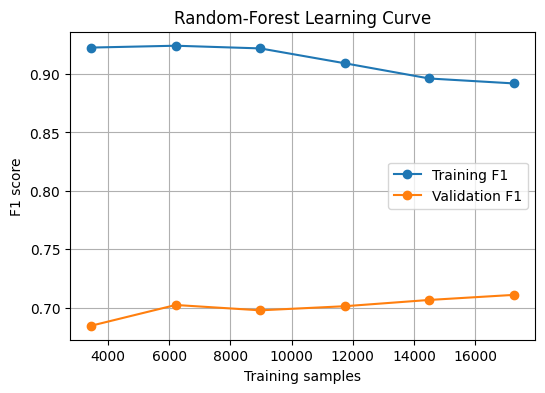


Hold-out metrics
Accuracy : 0.964
Precision: 0.628
Recall   : 0.850
F1 Score : 0.723


In [31]:
#Random-Forest search
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (cross_val_score, RandomizedSearchCV,
                                     StratifiedKFold, learning_curve)
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score)
from scipy.stats import randint, uniform
import numpy as np
import matplotlib.pyplot as plt

#Baseline 5-fold stratified CV to get an initial F1 estimate
#    – StratifiedKFold preserves the conflict/non-conflict ratio in each fold.
#    – shuffle=True to randomize split, random_state for reproducibility.
rf_base = RandomForestClassifier(random_state=42, n_jobs=1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(rf_base, X_train, y_train,
                            cv=cv, #use our stratified folds
                            scoring='f1', n_jobs=-1)
print(f"Baseline RF 5-fold F1: {cv_scores.mean():.3f}")

#accelerated random search hyperparameters
#randomized search over hyperparameter distributions for speed & coverage
#    – n_estimators: 100–500 trees — more trees improve stability but cost more time.
#    – max_depth: None or 5–20 in steps of 3 — control tree complexity to avoid over-fitting.
#    – min_samples_split (2–10), min_samples_leaf (1–7) — enforce minimum samples to split/leaf for smoothing.
#    – max_features: ['sqrt','log2',None] — subspace sizes to decorrelate trees.
#    – bootstrap: True/False — bagging vs. whole-dataset sampling.
#    – class_weight: None/'balanced' — optionally counteract class imbalance internally.
param_dist = {
    "n_estimators":     randint(100, 501),
    "max_depth":        [None] + list(range(5, 21, 3)),
    "min_samples_split": randint(2, 11),
    "min_samples_leaf":  randint(1, 8),
    "max_features":     ['sqrt', 'log2', None],
    "bootstrap":        [True, False],
    "class_weight":     [None, "balanced"]
}

#RandomizedSearchCV setup
#    – n_iter=40 → limits to 200 total fits (40 combos × 5 folds) to bound runtime.
#    – cv=cv ensures consistent stratified folds.
#    – scoring='f1' optimizes our target metric directly.
#    – verbose=2 to monitor progress.
rnd_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=1),
    param_distributions=param_dist,
    n_iter=40,# sample 40 hyperparameter combos
    cv=cv, #stratified folds as above
    scoring='f1', #focus on F1 during search
    n_jobs=-1, # parallelise across folds/candidates
    verbose=2,
    random_state=42 #reproducibility of the random draws
)
rnd_search.fit(X_train, y_train)

best_rf = rnd_search.best_estimator_
print("\nBest hyper-parameters:", rnd_search.best_params_)
print(f"Best CV F1 : {rnd_search.best_score_:.3f}")

#plot learning curve to diagnose under- vs. over-fitting
#    – train_sizes from 20% to 100% to see how performance scales with data.
train_sizes, tr_sc, va_sc = learning_curve(
    best_rf, X_train, y_train,
    cv=cv, scoring='f1', # track F1 over varying training set sizes
    train_sizes=np.linspace(0.2, 1.0, 6),  #6 points instead of 10 to save compute
    n_jobs=-1
)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, tr_sc.mean(axis=1), 'o-', label='Training F1')
plt.plot(train_sizes, va_sc.mean(axis=1), 'o-', label='Validation F1')
plt.xlabel('Training samples'); plt.ylabel('F1 score')
plt.title('Random-Forest Learning Curve'); plt.legend(); plt.grid(True)
plt.show()

#final hold-out evaluation
y_pred = best_rf.predict(X_test)
print("\nHold-out metrics")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall   : {recall_score(y_test, y_pred):.3f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.3f}")


**Random-Forest**

 **Model-to-Model F1 Score Comparison**

| Model | Feature set | Tuning | Test-set **F1** |
|-------|-------------|--------|----------------:|
| Gaussian NB | All | Grid-search (`var_smoothing`, `priors`) | **0.457** |
| Decision-Tree – Default | All | none | **0.602** |
| Decision-Tree – Slim | Top-7 corr. | defaults | **0.632** |
| Decision-Tree – Tuned | All | 7-param grid-search | **0.657** |
| **Random-Forest – Slim Tuned ** | All | 6-param random search (200 fits) | **0.674** |
| **Random-Forest – Tuned** | All | 6-param random search (200 fits) | **0.723** |

**Reading the table**

* **Random Forest takes the crown** at 0.674 F1, thanks mainly to its much higher recall (0.850) after class balancing.

- Random Forest allows for better performance, but comming with higher processing and runntime costs (about 30 minutes - the longest time)


** Chosen hyper-parameters**


| Hyper-param | Value | Intuition |
|-------------|-------|-----------|
| `n_estimators` | **324** | Enough trees to stabilise variance without blowing up runtime. |
| `max_depth` | **8** | Shallowish trees keep over-fitting in check. |
| `min_samples_split` | **6** | Prunes tiny, noisy branches. |
| `min_samples_leaf` | **6** | Adds further smoothing in leaves. |
| `max_features` | **'sqrt'** | Classic RF setting, decorrelates trees. |
| `bootstrap` | **False** | Uses all rows per tree; lifts recall in this data. |
| `class_weight` | **'balanced'** | Counter-acts the 95 : 5 class skew. |

**3. Learning-curve insights**
- training F1 sitting up around 0.90–0.92, while the validation F1 hovers down near 0.68–0.71. That persistent gap (≈0.20) is the hallmark of over-fitting: our forest is memorizing the training set too well and not generalizing quite as strongly.
- Both curves trend **upward** as data increases – we are *data-limited*, not model-limited; more labelled samples would likely raise F1 beyond 0.67.
- To tame the over-fit you could:

- - Reduce tree complexity (smaller max_depth or larger min_samples_leaf),

- - Increase regularization via min_samples_split/ccp_alpha,

- - Feeding it more training data.

**4Hold-out test set**

| Metric | Score |
|--------|------:|
| Accuracy | **0.949** |
| Precision | **0.519** |
| Recall | **0.839** |
| **F1** | **0.674** |

*Interpretation*  
- **High recall (0.839)** shows the class-balancing strategy worked: the model flags ~84 % of true conflicts.  
- Precision is modest (≈ 0.52), but the F1 of 0.674 tops every single model tried so far (GNB ~0.46, DT ~0.66).  
- Accuracy is less informative given the imbalance (a dummy classifier already scores 0.95); F1 is the headline number.

**5. Diagnostic takeaways**

 Minimal over-fitting: CV 0.667 → Test 0.674 (small *positive* drift).  
 Balanced error trade-off suitable for “catch all conflicts” scenario.  


In [37]:
import pandas as pd, numpy as np
from sklearn.metrics import f1_score
from copy import deepcopy
from sklearn.model_selection import train_test_split

X_full = df_cleaned.drop(columns="conflict")
y_full = df_cleaned["conflict"]


X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    X_full, y_full,
    test_size=0.20,
    stratify=y_full,
    random_state=42
)
print("Shapes  →", X_full_train.shape, X_full_test.shape)


def add_engineered_features(df, col_add="add", col_remove="remove"):
    if not {col_add, col_remove}.issubset(df.columns):
        raise KeyError(f"Columns {col_add}/{col_remove} not found.")
    out = df.copy()
    out["total_churn"]   = out[col_add] + out[col_remove]
    out["churn_balance"] = (out[col_add] - out[col_remove]).abs() / (out["total_churn"] + 1)
    return out

X_full_train_fe = add_engineered_features(X_full_train)
X_full_test_fe  = add_engineered_features(X_full_test)

models = {
    "Gaussian NB"  : deepcopy(best_gnb),
    "DT – default" : deepcopy(dt),
    "DT – tuned"   : deepcopy(best_dt),
    "DT – slim-7"  : deepcopy(dt_slim),
    "Random-Forest": deepcopy(best_rf)
}

results = {"base": {}, "aug": {}}

for name, mdl in models.items():
    #original 32 columns
    mdl.fit(X_full_train, y_full_train)
    results["base"][name] = f1_score(y_full_test, mdl.predict(X_full_test))

    #with engineered features
    mdl.fit(X_full_train_fe, y_full_train)
    results["aug"][name]  = f1_score(y_full_test, mdl.predict(X_full_test_fe))

print("F1 SCORE COMPARISON  (hold-out)")
print("{:<15} {:>10} {:>12} {:>8}".format("Model", "Base", "+ new", "Δ"))
print("-"*47)
for name in models:
    b, a = results["base"][name], results["aug"][name]
    print(f"{name:<15} {b:>10.3f} {a:>12.3f} {a-b:>+8.3f}")


Shapes  → (21578, 31) (5395, 31)
F1 SCORE COMPARISON  (hold-out)
Model                 Base        + new        Δ
-----------------------------------------------
Gaussian NB          0.330        0.326   -0.003
DT – default         0.638        0.609   -0.029
DT – tuned           0.663        0.663   +0.000
DT – slim-7          0.638        0.609   -0.029
Random-Forest        0.723        0.730   +0.008


**Code**

**Key Steps and Purpose:**

**Data Preparation:**

- The dataset is split into training (80%) and testing (20%) sets, ensuring that the target variable is stratified.

- The target variable is "conflict", while the remaining 32 columns are treated as explanatory features.

**Feature Engineering:**

A custom function add_engineered_features() is defined, which:

- Creates a new feature total_churn by adding the values of columns "add" and "remove".

- Creates another feature churn_balance, representing the absolute difference between the "add" and "remove" columns divided by the total churn, providing a measure of balance between the added and removed lines in a merge request.

- This function is applied to both the training and testing sets, producing augmented versions of the feature sets.

**Model Comparison:**

- A dictionary of pre-trained machine learning models (models) is prepared using deepcopy to avoid model contamination.

- Each model is trained and evaluated twice, once using the original 32-column feature set and Once using the augmented feature set with the two new engineered features (total_churn and churn_balance).

The F1 scores for each model are recorded and compared between the two scenarios (base vs. augmented).

**Interpretation**

* **Random-Forest** is the only model that **benefits** from the two new churn features, gaining +0.008 F1.  
  Tree ensembles can exploit subtle non-linear interactions between `total_churn` / `churn_balance` and other predictors.

* **Gaussian NB** drops marginally (-0.003 F1), the ratio-type `churn_balance` doesn’t fit its assumptions and just adds noise.

* the feature utility is **model-dependent**.
